# PS3

In [927]:
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sodapy import Socrata
import geopandas as gpd

## Getting Information of Crime using Socrata API

In [932]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
# client = Socrata("odn.data.socrata.com", None)

# Define App token
app_token = "0LMFzQvyVsDSPEu2ENiNZfEjV"

# Example authenticated client (needed for non-public datasets):
client = Socrata("odn.data.socrata.com",
                 app_token,
                 username="anzony.quispe@gmail.com",
                 password="Godisnotdead100")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("tt5s-y5fc", limit=50000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [933]:
# Keep 2015 rows
api_df = results_df[ results_df.year == "2015" ].copy()

# Spliting name columns
split_df = api_df.name.str.split( pat = ',', expand = True )
split_df.columns = [ 'city', 'state' ]

# Merging both dataframes
api_df = api_df.join( split_df ).copy()

# Checking unique values
print( api_df.state.unique() )

# We see there are blanks in unique values we want to drop those blanks
api_df['state'] = api_df.state.str.replace( " ", "")

# We want to keep only MD state
api_df_md = api_df[api_df.state == 'MD'].copy()

[' MD' ' VA' ' DC']


In [934]:
# converting crime_count string to float
api_df_md['crime_count'] = api_df_md.crime_count.astype(float)

# Get GEOID
api_df_md['GEOID'] = api_df_md.id.str[9:]

# Sum total crimes at geoid, year, month and incident_parent_type
df = api_df_md.groupby([ 'GEOID', 'year', 'month', 'incident_parent_type' ], as_index= False)['crime_count'].sum()

# Modifying incident_parent_type variable
df['incident_parent_type'] = df.incident_parent_type.str.lower() \
                            .str.replace(" ", "_")

# From long to wide
reshape_df = df.pivot( index = [ 'GEOID', "year", "month" ], columns = ['incident_parent_type'] )[['crime_count']].reset_index()

In [935]:
# Following instructions we replace null values with 0
# It is not the best approach, but we have to do it
reshape_df.fillna( 0, inplace = True)

## Scraping Zip Codes

Importing Data

In [936]:
# Get Information from ZipCode
# Request data
URL = "https://www.zipcodestogo.com/Maryland"
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:60.0) Gecko/20100101 Firefox/60.0"
}
web_page = requests.get(URL, headers=headers)
# html = BeautifulSoup(web_page.content, 'html.parser')

Cleaning Table

In [937]:
# Read all available tables in the page
# Select the table you want
zip_table = pd.read_html( web_page.content )[1]

# Drop the first two rows
zip_table = zip_table.drop( [0, 1] )

# Give column names
zip_table.columns = ['zip_code', 'city', 'county', 'zip_code_map']

# Drop duplicated rows
zip_table1 = zip_table.drop_duplicates( subset= 'zip_code')

After cleaning data of zips and dataset of crime, I want to inspect that both datasets have the same number of cities or at least, zip data should have more cities than dataset of crimes.

In [938]:
# Getting the number of cities
n_cities_crime = api_df_md.city.unique().size
n_cities_zip = zip_table1.city.unique().size 
n_cities_zip >= n_cities_crime

False

The inspection shows that crime data have more number of cities. It means the zip code data is incomplete. The objective of the assignment is to generate maps at the county level. It implies to  get weather information from the county median zip code, and aggregating city crime data at the county level. 
We identified the GEOID as a fixed id for the USA government shapefiles. Then, we noticed the ACS-5 year 2015 survey has this information. Using [this link](https://www2.census.gov/geo/tiger/TIGER2015/), we took shapefiles at 5-digit zipcode, places, and county levels. Our procedure is as follows:
1. We identified each zipcode and city with their corresponding county.
2. We get the median zip code and ensure that this median zip code exists. If it does not exist, we tried to replace it with any available zip code of their corresponding county.
3. We request weather data using API using the median zip code.
4. We aggregate crime data using GEOID after identifying their corresponding count.
5. We generate percapita crime data using the shapefile from [this link](https://hub.arcgis.com/datasets/23e45d260aba40fcb733361f5e236dd7_4).
6. We merge all data using county id.

## Merge City and Zipcode names with Counties

In [939]:
# Get the county level shapefile for all USA
county_us = gpd.read_file( r"..\_data\tl_2015_us_county\tl_2015_us_county.shp")
# We keep MD state
county_md = county_us[county_us.STATEFP == "24"].copy()

In [940]:
# Generate a folder
import os
newpath = r'..\_data\tl_2015_24_county' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
# Export MD county level shapefile in case we need it
county_md.to_file( r"..\_data\tl_2015_24_county\tl_2015_24_county.shp" )

c:\python\python38\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [941]:
# Import cities shapefile
places15md = gpd.read_file( r"..\_data\tl_2015_24_place\tl_2015_24_place.shp" )

# The main idea is to intersect centroids of Cities with shapefiles of Counties
# To know the CRS of this shapefile let use
places15md.crs

# flat projection
data_proj = places15md.to_crs("EPSG:3035")
#centroids in EPSG:4326
centroids_lat_lon = data_proj.geometry.centroid.to_crs( "EPSG:4269" )
centroids_lat_lon

# Get coordinates of centroids
places15md['Latitude_ctr'] = centroids_lat_lon.y
places15md['Longitude_ctr'] = centroids_lat_lon.x

# Centroids of cities
ctr_cities = pd.DataFrame( { 'GEOID' : places15md.GEOID.values, 'Latitude_ctr' : centroids_lat_lon.y, 'Longitude_ctr' : centroids_lat_lon.x})

# We generate a geopandas with Centroids
ctr_cities_geo = gpd.GeoDataFrame( ctr_cities , geometry= gpd.points_from_xy(ctr_cities.Longitude_ctr, ctr_cities.Latitude_ctr))
ctr_cities_geo = ctr_cities_geo.set_crs("EPSG:4269")

# we intersect centroids with counties
county_md_intersection = gpd.overlay( ctr_cities_geo , county_md , how='intersection')

In [942]:
# for this case we do not need the centroids we use representative point
# A point that is inside the polygon
repre_places = places15md.representative_point()

# Add these values to the main data set
places15md['Latitude_repre'] = repre_places.y
places15md['Longitude_repre'] = repre_places.x

In [943]:
# Centroids of cities
repre_cities = pd.DataFrame( { 'GEOID' : places15md.GEOID.values, 'Latitude_repre' : repre_places.y, 'Longitude_repre' : repre_places.x})

# We generate a geopandas with Centroids
repre_cities_geo = gpd.GeoDataFrame( repre_cities , geometry= gpd.points_from_xy(repre_cities.Longitude_repre, repre_cities.Latitude_repre))
repre_cities_geo = repre_cities_geo.set_crs("EPSG:4269")

# we intersect cities centroids with counties
county_md_intersection = gpd.overlay( repre_cities_geo , county_md , how='intersection')

# Rename columns 
city_county = county_md_intersection.rename( columns = { 'GEOID_1' : 'GEOID_city', 'GEOID_2' : 'GEOID_county' })

# Get idnetifiers of cities and counties
city_county = city_county[['GEOID_city', 'GEOID_county', 'COUNTYFP', 'NAME']]

In [944]:
# Get zip codes
zip_codes = gpd.read_file( r"..\_data\tl_2015_us_zcta510\tl_2015_us_zcta510.shp" )

# for this case we do not need the centroids we use representative point
# A point that is inside the polygon
repre_places = zip_codes.representative_point()

# Centroids of cities
repre_cities = pd.DataFrame( { 'ZCTA5CE10' : zip_codes.ZCTA5CE10.values, 'Latitude_repre' : repre_places.y, 'Longitude_repre' : repre_places.x})

# We generate a geopandas with Centroids
repre_cities_geo = gpd.GeoDataFrame( repre_cities , geometry= gpd.points_from_xy(repre_cities.Longitude_repre, repre_cities.Latitude_repre))
repre_cities_geo = repre_cities_geo.set_crs("EPSG:4269")

# we intersect cities centroids with counties
zip_countylvl = gpd.overlay( repre_cities_geo , county_md , how='intersection')

We already have every zipcode associeted with every county. Now, we want to get the zipcode median for every county.

In [945]:
# Get zipcode
zip_countylvl['zipcode'] = zip_countylvl.ZCTA5CE10.astype(float)

# Get median of zipcode at county level
county_zip_median = zip_countylvl.groupby( ['GEOID'], as_index = False )['zipcode'].median()

# Get zip median at county lvl
county_zip_median['zipcode'] = county_zip_median.zipcode.astype(int)

# # we need to check if the median zipcode exists
# For this reason we will to 
median_zip = county_zip_median['zipcode'].tolist()
total_zipcode = zip_countylvl.ZCTA5CE10.astype(int).tolist()
list_error_zip = set( median_zip ).difference( total_zipcode)
print(list_error_zip)

# # We see there is some median zipcodes that do not exist in  null values in this dataset
for error_zip in list_error_zip:
    county_zip_median.loc[ county_zip_median.zipcode == error_zip, 'zipcode' ] = error_zip - 1
    
# test Again
median_zip = county_zip_median['zipcode'].tolist()
total_zipcode = zip_countylvl.ZCTA5CE10.astype(int).tolist()
list_error_zip = set( median_zip ).difference( total_zipcode)
print(list_error_zip)

# # We see there is some median zipcodes that do not exist in  null values in this dataset
for error_zip in list_error_zip:
    county_zip_median.loc[ county_zip_median.zipcode == error_zip, 'zipcode' ] = error_zip - 1

# test Again
median_zip = county_zip_median['zipcode'].tolist()
total_zipcode = zip_countylvl.ZCTA5CE10.astype(int).tolist()
list_error_zip = set( median_zip ).difference( total_zipcode)
print(list_error_zip)

# # We see there is some median zipcodes that do not exist in  null values in this dataset
for error_zip in list_error_zip:
    county_zip_median.loc[ county_zip_median.zipcode == error_zip, 'zipcode' ] = error_zip - 1

# test Again
median_zip = county_zip_median['zipcode'].tolist()
total_zipcode = zip_countylvl.ZCTA5CE10.astype(int).tolist()
list_error_zip = set( median_zip ).difference( total_zipcode)
print(list_error_zip)

# # We see there is some median zipcodes that do not exist in  null values in this dataset
for error_zip in list_error_zip:
    county_zip_median.loc[ county_zip_median.zipcode == error_zip, 'zipcode' ] = error_zip - 1

# test Again
median_zip = county_zip_median['zipcode'].tolist()
total_zipcode = zip_countylvl.ZCTA5CE10.astype(int).tolist()
list_error_zip = set( median_zip ).difference( total_zipcode)
print(list_error_zip)

# Now we have no errors in zipcodes

{20681, 21748, 21845, 21846, 21759}
{21747, 21844, 21845}
{21843, 21844}
{21843}
set()


We need the identifier of county, cities and the median zipcode.

In [946]:
# Get all idnetifiers to merge with the main data
cross_table = city_county.merge( county_zip_median, left_on = 'GEOID_county', right_on= 'GEOID' )

# In string values
cross_table['zipcode'] = cross_table.zipcode.astype(int).astype(str)

# Rename columns
cross_table = cross_table.rename( columns = { 'zipcode' : 'zipcode_median' } ) 

We already have the meadian zipcode for every county. 

## Getting wether data for zip median code

In [947]:
# Install wwo-hist
# !pip install wwo-hist

from wwo_hist import retrieve_hist_data

In [948]:
# Get zip code in a list
zipcode_median_list = cross_table.zipcode_median.unique().tolist()

In [949]:
# frequency = 24
# start_date = '01-JAN-2015'
# end_date = '31-DEC-2015'
# api_key = 'a6e8c80275bf409c8eb140629221607'


# # Getting data for zip
# data = retrieve_hist_data(api_key,
#                             zipcode_median_list,
#                             start_date,
#                             end_date,
#                             frequency,
#                             location_label = False,
#                             export_csv = True,
#                             store_df = True)


In [950]:
# Concatenate all pdf
all_data = pd.concat( data )
# all_data.to_excel( r"weather_data.xlsx" )

# Get month of every date
all_data['month'] = all_data['date_time'].dt.month

# Get year of every date
all_data['year'] = all_data['date_time'].dt.year

In [951]:
# Converting hours to dates
date_time_cols = [ 'moonrise', 'moonset', 'sunrise', 'sunset']
for col in date_time_cols:
    # Change datetimes
    all_data[ f'{col}_hr' ] = pd.to_datetime( all_data[ f'{col}' ], format = '%I:%M %p', errors = 'coerce' )
    all_data[ f'{col}_hr' ] = ( all_data[ f'{col}_hr' ].dt.hour + all_data[ f'{col}_hr' ].dt.minute / 60 ).round( 2 )

In [952]:
# Drop hour time 
all_data = all_data.drop( date_time_cols + ['date_time'], axis = 1 )

In [953]:
# Converting object columns to float columns
float_cols = all_data.dtypes.index[:-7].tolist()
for col in float_cols:
    all_data[ col ] = all_data[ col ].astype( float )

In [954]:
# Change column names
all_data = all_data.rename( columns = { 'location' : 'zipcode' } )

In [955]:
# Mean of wether data
weather_data = all_data.groupby( ['zipcode', 'year', 'month',  ], as_index = False ).mean().round(2)

## Merging All Data

In [956]:
reshape_df.columns = [ 'GEOID',
                        'year',
                        'month',
                        'alarm',
                        'arson',
                        'assault',
                        'assault_with_deadly_weapon',
                        'breaking_&_entering',
                        'community_policing',
                        'death',
                        'disorder',
                        'drugs',
                        'emergency',
                        'family_offense',
                        'fire',
                        'homicide',
                        'kidnapping',
                        'liquor',
                        'missing_person',
                        'other',
                        'other_sexual_offense',
                        'pedestrian_stop',
                        'property_crime',
                        'quality_of_life',
                        'robbery',
                        'sexual_assault',
                        'sexual_offense',
                        'theft',
                        'theft_from_vehicle',
                        'theft_of_vehicle',
                        'traffic',
                        'vehicle_recovery',
                        'vehicle_stop',
                        'weapons_offense']

In [957]:
# Merge to get county code
crime_data = reshape_df.merge( cross_table, left_on = 'GEOID', right_on = 'GEOID_city')

# Sum columns at county level
crime_data = crime_data.groupby( [ 'COUNTYFP', 'year', 'month' ] , as_index = False ).sum()

# Import county shapefiles with population
md_county = gpd.read_file( r"..\_data\Maryland_Counties\Maryland_Counties.shp" )

# We need population data
crime_data = crime_data.merge( md_county[ [ 'CNTY_FIPS', 'POPULATION' ] ], left_on = 'COUNTYFP', right_on= 'CNTY_FIPS' )

# Get percapita data
float_cols = crime_data.dtypes.index.tolist()[3:-2]

# Get percapita data
for col in float_cols:
    
    crime_data[ f'{col}' ] = crime_data[ col ] * 100000 / crime_data[ 'POPULATION' ]
    crime_data = crime_data.rename( columns = { col : f'{col}100000' } )

Dealing with wether data

In [958]:
# We have to drop duplicated median zipcodes
weather_db = weather_data.drop_duplicates( subset = ['zipcode', 'year', 'month'])

# Get county code with zipcode
zip_county = cross_table.drop_duplicates( subset = 'COUNTYFP')
weather_db = zip_county.merge(  weather_data, right_on = 'zipcode', left_on = 'zipcode_median', how = 'outer' )

# Make year and month dates as object
weather_db['year'] = weather_db['year'].astype( str )
weather_db['month'] = weather_db['month'].astype( str )

In [959]:
# Merge all data
all_merge_data = crime_data.merge( weather_db, on = ['COUNTYFP', 'year', 'month'], how = 'outer')

In [960]:
# Save data
all_merge_data.to_excel( r'final_data.xlsx' )

## Plots

In [961]:
crime_cols = ['alarm100000', 'arson100000',
       'assault100000', 'assault_with_deadly_weapon100000',
       'breaking_&_entering100000', 'community_policing100000', 'death100000',
       'disorder100000', 'drugs100000', 'emergency100000',
       'family_offense100000', 'fire100000', 'homicide100000',
       'kidnapping100000', 'liquor100000', 'missing_person100000',
       'other100000', 'other_sexual_offense100000', 'pedestrian_stop100000',
       'property_crime100000', 'quality_of_life100000', 'robbery100000',
       'sexual_assault100000', 'sexual_offense100000', 'theft100000',
       'theft_from_vehicle100000', 'theft_of_vehicle100000', 'traffic100000',
       'vehicle_recovery100000', 'vehicle_stop100000', 'weapons_offense100000']

In [962]:
w_cols = ['maxtempC', 'mintempC',
       'totalSnow_cm', 'sunHour', 'uvIndex', 'moon_illumination', 'DewPointC',
       'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover',
       'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
       'winddirDegree', 'windspeedKmph', 'moonrise_hr', 'moonset_hr',
       'sunrise_hr', 'sunset_hr']

In [963]:
# Generating Bins for each weather column
for col in w_cols:
    all_merge_data[ f'{col}_bin'] = pd.qcut(all_merge_data[col], q = 15, duplicates = 'drop', precision=2 ).apply( lambda x: x.mid )

Inspect all possible plots with all the weather and crime variables.

In [964]:
# # Generating plots for all columns
# for y in crime_cols:
#     for x in w_cols:
#         fig, ax = plt.subplots(figsize=(8, 5))
#         point_plot = sns.pointplot(data=all_merge_data, x= f"{x}_bin", y= y )

Final plots

c:\python\python38\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


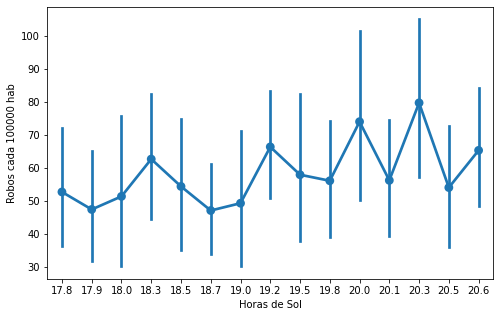

In [965]:
fig, ax = plt.subplots(figsize=(8, 5)) 
point_plot = sns.pointplot( data = all_merge_data, x= "sunset_hr_bin", y= "theft100000")

label_ticks = []
for tick_label in point_plot.get_xticklabels():
    text = np.round( float( tick_label.get_text() ), 1 )
    label_ticks.append( f'{text}')
#     tick_label.set_rotation(90)

ax.set_xticklabels( label_ticks )
ax.set(xlabel = f'Horas de Sol', ylabel= 'Robos cada 100000 hab')

fig.savefig("_Figures/sunset_hr_theft.png") 

c:\python\python38\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


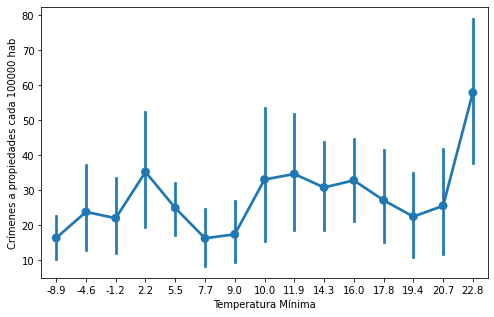

In [966]:
fig, ax = plt.subplots(figsize=(8, 5)) 
point_plot = sns.pointplot(data=all_merge_data, x= "mintempC_bin", y= "property_crime100000")

label_ticks = []
for tick_label in point_plot.get_xticklabels():
    text = np.round( float( tick_label.get_text() ), 1 )
    label_ticks.append( f'{text}')
#     tick_label.set_rotation(90)

ax.set_xticklabels( label_ticks )
ax.set(xlabel = f'Temperatura Mínima', ylabel= 'Crímenes a propiedades cada 100000 hab')

fig.savefig("_Figures/mintemp_property_crime.png") 

c:\python\python38\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


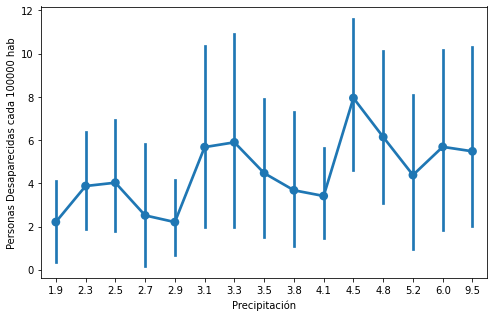

In [971]:
fig, ax = plt.subplots(figsize=(8, 5)) 
point_plot = sns.pointplot(data=all_merge_data, x= "precipMM_bin", y= "missing_person100000")

label_ticks = []
for tick_label in point_plot.get_xticklabels():
    text = np.round( float( tick_label.get_text() ), 1 )
    label_ticks.append( f'{text}')

ax.set_xticklabels(label_ticks)
ax.set(xlabel = f'Precipitación', ylabel='Personas Desaparecidas cada 100000 hab')

fig.savefig("_Figures/precipMM_missing_person.png") 

c:\python\python38\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


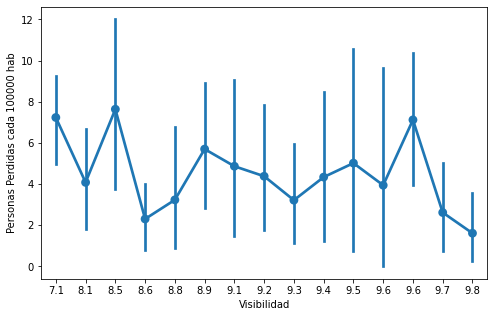

In [968]:
fig, ax = plt.subplots(figsize=(8, 5)) 
point_plot = sns.pointplot(data=all_merge_data, x= "visibility_bin", y= "missing_person100000")

label_ticks = []
for tick_label in point_plot.get_xticklabels():
    text = np.round( float( tick_label.get_text() ), 1 )
    label_ticks.append( f'{text}')

ax.set_xticklabels(label_ticks)
ax.set(xlabel = f'Visibilidad', ylabel='Personas Perdidas cada 100000 hab')

fig.savefig("_Figures/visibility_missing_person.png") 

c:\python\python38\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


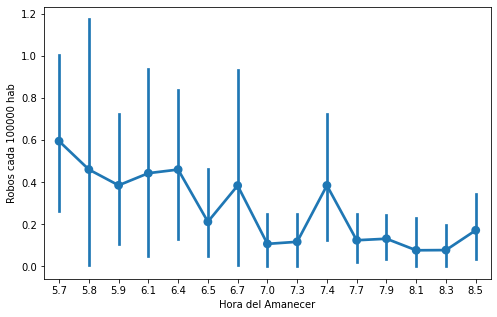

In [969]:
fig, ax = plt.subplots(figsize=(8, 5)) 
point_plot = sns.pointplot(data=all_merge_data, x= "sunrise_hr_bin", y= "arson100000")

label_ticks = []
for tick_label in point_plot.get_xticklabels():
    text = np.round( float( tick_label.get_text() ), 1 )
    label_ticks.append( f'{text}')

ax.set_xticklabels(label_ticks)
ax.set(xlabel = f'Hora del Amanecer', ylabel='Robos cada 100000 hab')

fig.savefig("_Figures/sunrise_hr_arson.png") 

c:\python\python38\lib\site-packages\seaborn\categorical.py:253: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped_vals = vals.groupby(grouper)


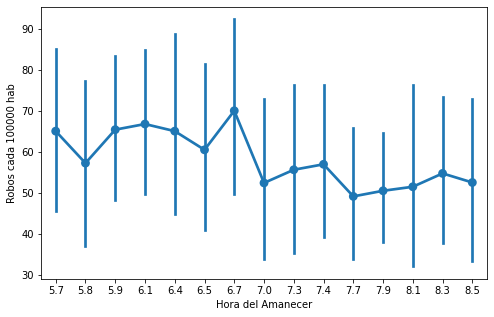

In [970]:
fig, ax = plt.subplots(figsize=(8, 5)) 
point_plot = sns.pointplot(data=all_merge_data, x= "sunrise_hr_bin", y= "theft100000")

label_ticks = []
for tick_label in point_plot.get_xticklabels():
    text = np.round( float( tick_label.get_text() ), 1 )
    label_ticks.append( f'{text}')

ax.set_xticklabels(label_ticks)
ax.set(xlabel = f'Hora del Amanecer', ylabel='Robos cada 100000 hab')

fig.savefig("_Figures/sunrise_hr_theft.png") 